In [1]:
import os
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

In [2]:
def read_file(filename, columns=None, **kwargs):
    print(filename)
    load_extension = os.path.splitext(filename)[-1]
    if load_extension == ".parquet":
        return pd.read_parquet(filename, columns=columns,**kwargs)
    elif load_extension == ".csv":
        return pd.read_csv(filename, usecols=columns, **kwargs)

In [3]:
fpath = '/local-scratch/nigam/projects/lguo/temp_ds_shift_robustness/clmbr/cohorts/admissions/cohort/'
df = read_file(f"{fpath}/cohort_split.parquet",engine='pyarrow')
df['admission_year']=df['admit_date'].dt.year
df = df.query("admission_year>2008")

/local-scratch/nigam/projects/lguo/temp_ds_shift_robustness/clmbr/cohorts/admissions/cohort//cohort_split.parquet


In [4]:
# Confirm that each person_id is unique
print(
    df.shape[0],
    df['person_id'].nunique(),
)

211230 211230


In [5]:
df['gender_female'] = np.where(df['gender_concept_name']=='FEMALE',1,0)
df['gender_male'] = np.where(df['gender_concept_name']=='MALE',1,0)
df['race_white'] = np.where(df['race_eth']=='White',1,0)
df['race_other'] = np.where(df['race_eth']=='White',0,1)

In [6]:
for var in ['admission_year']:
    df_agg = df.groupby(var).agg(
        subject_count = ('person_id', 'count'),
        age_mean = ('age_in_years','mean'),
        age_std = ('age_in_years','std'),
        gender_F = ('gender_female','sum'),
        gender_M = ('gender_male','sum'),
        race_W = ('race_white','sum'),
        race_O = ('race_other','sum'),
        mortality = ('hospital_mortality','sum'),
        los_7 = ('LOS_7','sum'),
        readmission_30 = ('readmission_30','sum'),
        icu = ('icu_admission','sum'),
        subject_count_readmission = ('readmission_30','count'),
    ).reset_index().round(2)

    df_agg['gender_F_perc'] = df_agg['gender_F']/df_agg['subject_count']*100
    df_agg['gender_M_perc'] = df_agg['gender_M']/df_agg['subject_count']*100
    df_agg['race_W_perc'] = df_agg['race_W']/df_agg['subject_count']*100
    df_agg['race_O_perc'] = df_agg['race_O']/df_agg['subject_count']*100
    df_agg['mortality_perc'] = df_agg['mortality']/df_agg['subject_count']*100
    df_agg['los_7_perc'] = df_agg['los_7']/df_agg['subject_count']*100
    df_agg['readmission_30_perc'] = df_agg['readmission_30']/df_agg['subject_count_readmission']*100
    df_agg['icu_perc'] = df_agg['icu']/df_agg['subject_count']*100

    df_agg['Age'] = df_agg['age_mean'].apply('{:.0f}'.format)+'±'+df_agg['age_std'].apply('{:.0f}'.format)+''

    df_agg['Gender (Female)'] = df_agg['gender_F'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['gender_F_perc'].apply('{:.0f}'.format)+'%)'

    df_agg['Gender (Male)'] = df_agg['gender_M'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['gender_M_perc'].apply('{:.0f}'.format)+'%)'

    df_agg['Race (White)'] = df_agg['race_W'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['race_W_perc'].apply('{:.0f}'.format)+'%)'

    df_agg['Race (Other)'] = df_agg['race_O'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['race_O_perc'].apply('{:.0f}'.format)+'%)'

    df_agg['In-Hospital Mortality'] = df_agg['mortality'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['mortality_perc'].apply('{:.0f}'.format)+'%)'
    
    df_agg['LOS >7 Days'] = df_agg['los_7'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['los_7_perc'].apply('{:.0f}'.format)+'%)'

    df_agg['Readmission 30 Days'] = df_agg['readmission_30'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['readmission_30_perc'].apply('{:.0f}'.format)+'%)'
    
    df_agg['ICU Admission'] = df_agg['icu'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['icu_perc'].apply('{:.0f}'.format)+'%)'

    df_agg = df_agg[['subject_count',var,'Age','Gender (Female)','Gender (Male)','Race (White)','Race (Other)','In-Hospital Mortality','LOS >7 Days','Readmission 30 Days','ICU Admission']]
    df_agg = df_agg.melt(id_vars=var)
    df_agg = df_agg.pivot(columns = var, values = 'value', index = 'variable')
    df_agg = df_agg.reindex(labels = [
        'subject_count',
        'Age',
        'Gender (Female)',
        'Gender (Male)',
        'Race (White)', 
        'Race (Other)',
        'In-Hospital Mortality',
        'LOS >7 Days',
        'Readmission 30 Days',
        'ICU Admission'
    ])
    display(df_agg)

admission_year,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
variable,,,,,,,,,,,,,
subject_count,12727,12930,13104,13136,13117,15235,17241,16980,17198,21187,22514,22352,13509
Age,57±18,57±18,57±18,57±18,57±18,53±19,52±19,52±19,53±19,53±20,53±20,53±20,54±20
Gender (Female),6572 (52%),6579 (51%),6767 (52%),6576 (50%),6668 (51%),8820 (58%),10483 (61%),10310 (61%),10269 (60%),12874 (61%),13556 (60%),13234 (59%),8010 (59%)
Gender (Male),6154 (48%),6351 (49%),6337 (48%),6559 (50%),6448 (49%),6414 (42%),6757 (39%),6670 (39%),6929 (40%),8313 (39%),8956 (40%),9116 (41%),5496 (41%)
Race (White),7054 (55%),8106 (63%),8091 (62%),7848 (60%),7585 (58%),8092 (53%),8620 (50%),8174 (48%),8328 (48%),10164 (48%),10866 (48%),10101 (45%),5908 (44%)
Race (Other),5673 (45%),4824 (37%),5013 (38%),5288 (40%),5532 (42%),7143 (47%),8621 (50%),8806 (52%),8870 (52%),11023 (52%),11648 (52%),12251 (55%),7601 (56%)
In-Hospital Mortality,267 (2%),317 (2%),337 (3%),337 (3%),340 (3%),321 (2%),345 (2%),345 (2%),335 (2%),402 (2%),379 (2%),459 (2%),249 (2%)
LOS >7 Days,2680 (21%),2718 (21%),2719 (21%),2739 (21%),2703 (21%),2939 (19%),3065 (18%),3364 (20%),3263 (19%),3767 (18%),4078 (18%),4300 (19%),2709 (20%)
Readmission 30 Days,658 (5%),760 (6%),706 (6%),681 (5%),687 (5%),780 (5%),813 (5%),767 (5%),762 (5%),1012 (5%),1079 (5%),1080 (5%),619 (5%)


##### Proportion of admit_date and discharge_date that are at midnight

In [7]:
admit_diff = (df.admit_date - pd.to_datetime(df.admit_date.dt.date)) / np.timedelta64(1,'h')
discharge_diff = (df.discharge_date - pd.to_datetime(df.discharge_date.dt.date)) / np.timedelta64(1,'h')
print(
    f"admit_time at midnight [%]: {round(np.mean(admit_diff==0)*100,4)}\n"
    f"discharge_time at midnight [%]: {round(np.mean(admit_diff==0)*100,4)}"
)

admit_time at midnight [%]: 0.0473
discharge_time at midnight [%]: 0.0473


##### LOS distribution in minutes

In [8]:
idf = df[~df['LOS_7'].isnull()]
los = round((idf.discharge_date - idf.admit_date) / np.timedelta64(1,'m'))

(0.0, 10000.0)

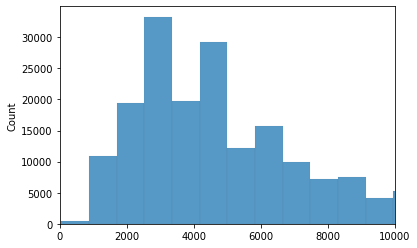

In [9]:
ax = sns.histplot(los,kde=False,bins=1000)
ax.set_xlim([0,10000])

In [10]:
min(los)

42.0

In [11]:
len(np.where(los<60)[0])

1

##### Prevalence by Year and Split

In [12]:
folds = df['fold_id'].unique().tolist()
years = df['admission_year'].unique().tolist()
tasks = ['hospital_mortality','LOS_7','readmission_30','icu_admission']
df_v = pd.DataFrame(columns=['year','fold','task','count','perc'])
c=0
for year in years:
    for fold in folds:
        for task in tasks:
            c+=1
            sample = df.query(f"{task}_fold_id==@fold and admission_year==@year")
            df_v.loc[c,:]=[year,fold,task,sample[task].sum(),sample[task].mean()]

In [13]:
df_v.pivot(index=['task','fold'],columns='year',values=['perc'])

perc                                          \
year                         2009      2010      2011      2012      2013   
task               fold                                                     
LOS_7              1     0.222923  0.201794  0.204533  0.200878  0.206839   
                   2     0.197809  0.210378  0.212038  0.202518  0.211771   
                   3     0.220495  0.219898  0.213415  0.213778  0.202525   
                   4     0.197827  0.207365  0.217871  0.217724  0.203306   
                   5      0.21113  0.231859  0.201875  0.218252  0.209863   
                   test   0.22157  0.205573  0.210445  0.212788  0.220174   
                   val   0.234409  0.225959  0.212152   0.20543   0.20082   
hospital_mortality 1     0.026361  0.022422  0.026534  0.026894  0.028682   
                   2     0.024798  0.021997  0.024848  0.021346  0.024202   
                   3     0.021301  0.019785  0.021619  0.030071  0.026894   
                   4     0.021155  0.027762  0.022063  0.024617  0.024793   
                   5     0.022375  0.028912   0.02813  0.028037  0.032329   
                   test  0.013881  0.028391   0.02999  0.024041   0.02509   
                   val   0.020968  0.025749  0.028836  0.026127  0.021516   
icu_admission      1     0.014646  0.034058  0.032948  0.025952  0.028307   
                   2     0.013482  0.026128  0.031627  0.021179  0.026027   
                   3     0.008221  0.026175  0.025419  0.034423  0.027183   
                   4     0.006973  0.024911  0.022583  0.025258  0.032929   
                   5     0.007558  0.024332  0.026042  0.024207  0.031432   
                   test  0.008686  0.025838  0.025419  0.029443  0.029095   
                   val   0.007135  0.021583  0.021622  0.022508   0.02694   
readmission_30     1     0.045401   0.05977  0.054193  0.055493  0.057517   
                   2     0.054599  0.071718  0.058523  0.054964  0.058724   
                   3     0.061285  0.053179  0.044343  0.058258  0.046919   
                   4     0.049209  0.057444  0.062961  0.059819    0.0453   
                   5     0.055359  0.063343  0.056948  0.054039  0.058556   
                   test   0.06087  0.072866  0.057816   0.05313  0.057368   
                   val    0.05237   0.05423  0.059168  0.042216  0.056286   

                                                                           \
year                         2014      2015      2016      2017      2018   
task               fold                                                     
LOS_7              1     0.197449  0.166806  0.216801  0.202177  0.164398   
                   2     0.204362  0.173149  0.207715  0.194794   0.18884   
                   3     0.191399  0.182728   0.19221  0.177284   0.17777   
                   4     0.188831   0.18432  0.204594  0.196728  0.177513   
                   5     0.204265  0.193737  0.196003   0.19505  0.186371   
                   test  0.183341  0.174708  0.194048  0.177344  0.184076   
                   val   0.193392  0.178669  0.189457  0.197729  0.177778   
hospital_mortality 1     0.021729   0.01714  0.023759  0.019255  0.017359   
                   2     0.026079   0.02133  0.022467  0.021411  0.020075   
                   3     0.021739  0.016688  0.019475   0.01886  0.023114   
                   4      0.02461   0.02377  0.014462  0.022232  0.019421   
                   5     0.021327  0.018372  0.022109  0.021393  0.020443   
                   test  0.017629  0.022957  0.021032  0.019141  0.022293   
                   val     0.0163  0.020631  0.020214  0.015662  0.011746   
icu_admission      1     0.028051  0.023468  0.034041  0.024675  0.022412   
                   2     0.028543  0.029767  0.025495  0.032088  0.029464   
                   3     0.018236  0.022087  0.027864  0.023458  0.032523   
                   4     0.030973  0.022068  0.031278      0.02  0.035382   
                   5    